## Import and Preprocess Data

Importing necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import re
import nltk
import sys

import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
from time import time


Importing dataset

In [2]:
imdb_data = pd.read_excel('/content/drive/MyDrive/csv/IMDB_dataset.xlsx')
print(imdb_data.shape)
imdb_data.head(10)

(25000, 2)


,review,sentiment
0,I thought this was a wonderful way to spend ti...,positive
1,"Probably my all-time favorite movie, a story o...",positive
2,I sure would like to see a resurrection of a u...,positive
3,"This show was an amazing, fresh & innovative i...",negative
4,Encouraged by the positive comments about this...,negative
5,Phil the Alien is one of those quirky films wh...,negative
6,I saw this movie when I was about 12 when it c...,negative
7,So im not a big fan of Boll's work but then ag...,negative
8,This a fantastic movie of three prisoners who ...,positive
9,This movie made it into one of my top 10 most ...,negative


In [3]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     25000 non-null  object
 1   sentiment  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [4]:
print(imdb_data["review"][0])

I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.


Preprocess Text Data

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
import pickle
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


If we did the process earlier, we write it on a file and read from there to prevent time consuming

In [6]:
flag = os.stat("/content/drive/MyDrive/csv/corpus.txt").st_size != 0

if not flag:
  imdb_data_len = len(imdb_data.iloc[:, 0])
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')

  ps = PorterStemmer()


  # new list with cleaned data
  corpus = []
  for i in range(imdb_data_len): # this can also be written as imdb_data['review']
    review = BeautifulSoup(imdb_data['review'][i], "html.parser").get_text()
    review = re.sub('\[[^]]*\]',' ',review)
    review = re.sub('[^a-zA-z0-9]',' ',review)
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
    review = ' '.join(review)

    corpus.append(review)
  pickle.dump(corpus, open( "/content/drive/MyDrive/csv/corpus.txt", "wb" ))

else:
  corpus = pickle.load(open( "/content/drive/MyDrive/csv/corpus.txt", "rb" ))
print(corpus[0])

thought wonder way spend time hot summer weekend sit air condit theater watch light heart comedi plot simplist dialogu witti charact likabl even well bread suspect serial killer may disappoint realiz not match point 2 risk addict thought proof woodi allen still fulli control style mani us grown love laugh one woodi comedi year dare say decad never impress scarlet johanson manag tone sexi imag jump right averag spirit young woman may not crown jewel career wittier devil wear prada interest superman great comedi go see friend


Positive words


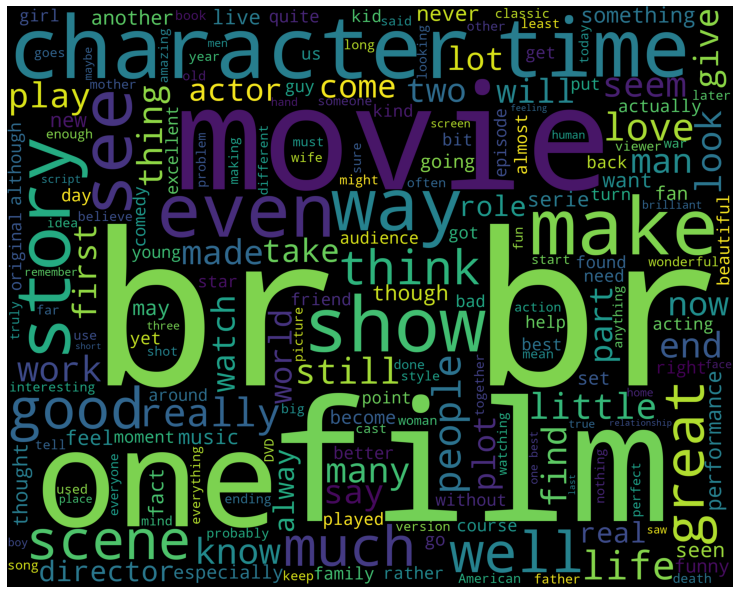

Negative words


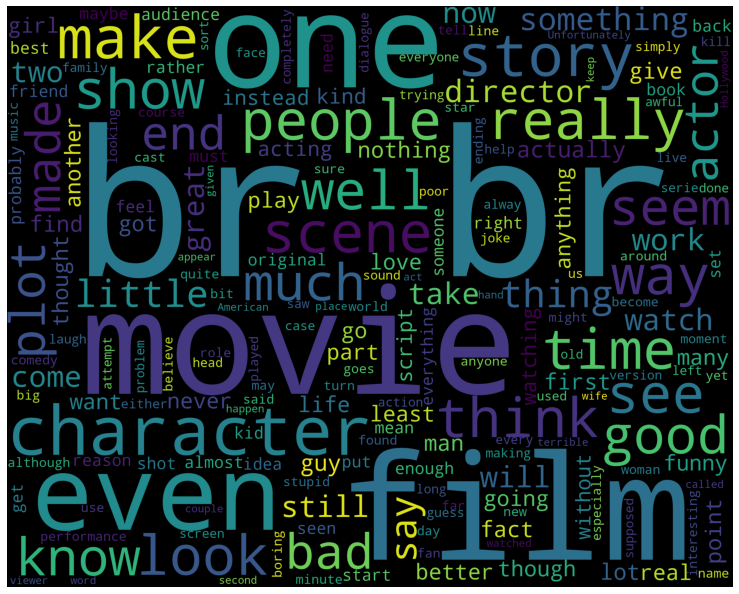

In [16]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

train, test = train_test_split(imdb_data,test_size = 0.2)
# Removing neutral sentiments
train = train[train.sentiment != "Neutral"]

train_pos = train[ train['sentiment'] == 'positive']
train_pos = train_pos['review']
train_neg = train[ train['sentiment'] == 'negative']
train_neg = train_neg['review']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos)
print("Negative words")
wordcloud_draw(train_neg)

## Tfid Vectorization

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Tfidf vectorizer
tv=TfidfVectorizer(max_features=12500)
x_tv=tv.fit_transform(corpus).toarray()

y = imdb_data.iloc[:,1].values
bin_y = np.ndarray((25000,1))
for i,item in enumerate(y):
  bin_y[i] = 1 if item == "positive" else 0
y = bin_y

In [8]:
x_tv_train, x_tv_test, y_tv_train, y_tv_test = train_test_split(x_tv, y, test_size= 0.2, random_state=999)
x_tv_test, x_val, y_tv_test, y_val = train_test_split(x_tv_test, y_tv_test, test_size= 0.5, random_state=15)

## Grid Search Cross Validation

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score

models = {}

def print_results(results):
  print('Best Parameters: {}'.format(results.best_params_))
    
  means= results.cv_results_['mean_test_score']
  stds = results.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, results.cv_results_['params']):
    print("{} (+/-{}) for {}".format(round(mean, 3), round(std *2,3), params))
        
def evaluate_model(name, model, features, labels):
  start = time()
  pred = model.predict(features)
  end = time()
  accuracy = round(accuracy_score(labels, pred), 3)
  precision = round(precision_score(labels, pred, average = 'weighted'),3)
  recall = round(recall_score(labels,pred, average= "weighted"),3)
  print("{} \n\tAccuracy: {}\n\tPrecision: {}\n\tRecall: {}\n\tLatency: {}ms".format(
    name,
    accuracy,
    precision,
    recall,
    round((end-start),3)
))

### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

parameters = {
    'n_estimators': [5, 50, 100],
    'max_depth': [2, 10, 20, None]
}

rf.fit(x_tv_train, y_tv_train.ravel())

RandomForestClassifier()

In [11]:
%%time
cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(x_tv_train, y_tv_train.ravel())
models["Random Forest"] = cv.best_estimator_
print_results(cv)

Best Parameters: {'max_depth': None, 'n_estimators': 100}
0.62 (+/-0.067) for {'max_depth': 2, 'n_estimators': 5}
0.756 (+/-0.021) for {'max_depth': 2, 'n_estimators': 50}
0.787 (+/-0.014) for {'max_depth': 2, 'n_estimators': 100}
0.704 (+/-0.016) for {'max_depth': 10, 'n_estimators': 5}
0.821 (+/-0.009) for {'max_depth': 10, 'n_estimators': 50}
0.83 (+/-0.014) for {'max_depth': 10, 'n_estimators': 100}
0.732 (+/-0.017) for {'max_depth': 20, 'n_estimators': 5}
0.829 (+/-0.013) for {'max_depth': 20, 'n_estimators': 50}
0.843 (+/-0.018) for {'max_depth': 20, 'n_estimators': 100}
0.735 (+/-0.016) for {'max_depth': None, 'n_estimators': 5}
0.836 (+/-0.012) for {'max_depth': None, 'n_estimators': 50}
0.848 (+/-0.013) for {'max_depth': None, 'n_estimators': 100}
CPU times: user 23min 48s, sys: 3.95 s, total: 23min 52s
Wall time: 23min 50s


### Gradient Boosting

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(learning_rate = 0.1,max_features='sqrt', min_samples_leaf=50,
                           min_samples_split=500, random_state=999,
                           subsample=0.5)
parameters = {
    'n_estimators': [5, 50, 100],
    'max_depth': [2, 10, 20, None]
}
gb.fit(x_tv_train, y_tv_train.ravel())
print('done')

done


In [13]:
%%time
cv_gb = GridSearchCV(estimator = gb, param_grid = parameters, cv=5)
cv_gb.fit(x_tv_train, y_tv_train.ravel())

models["Gradient Boosting"] = cv_gb.best_estimator_
print_results(cv_gb)

Best Parameters: {'max_depth': None, 'n_estimators': 100}
0.638 (+/-0.026) for {'max_depth': 2, 'n_estimators': 5}
0.775 (+/-0.017) for {'max_depth': 2, 'n_estimators': 50}
0.807 (+/-0.012) for {'max_depth': 2, 'n_estimators': 100}
0.735 (+/-0.023) for {'max_depth': 10, 'n_estimators': 5}
0.835 (+/-0.011) for {'max_depth': 10, 'n_estimators': 50}
0.85 (+/-0.011) for {'max_depth': 10, 'n_estimators': 100}
0.75 (+/-0.028) for {'max_depth': 20, 'n_estimators': 5}
0.844 (+/-0.008) for {'max_depth': 20, 'n_estimators': 50}
0.859 (+/-0.012) for {'max_depth': 20, 'n_estimators': 100}
0.755 (+/-0.022) for {'max_depth': None, 'n_estimators': 5}
0.849 (+/-0.009) for {'max_depth': None, 'n_estimators': 50}
0.861 (+/-0.009) for {'max_depth': None, 'n_estimators': 100}
CPU times: user 13min 14s, sys: 903 ms, total: 13min 15s
Wall time: 13min 15s


### Evaluation

In [14]:
for name, mdl in models.items():
  evaluate_model(name, mdl, x_val, y_val)

Random Forest 
	Accuracy: 0.842
	Precision: 0.842
	Recall: 0.842
	Latency: 0.777ms
Gradient Boosting 
	Accuracy: 0.862
	Precision: 0.862
	Recall: 0.862
	Latency: 0.161ms


## Conclusion

Tests shows that Gradient Boosting has greater Accuracy, Precision, Recall and less Latency from Random Forest. For this situation, Gradient Boosting is the better algorithm.